# Model bias analysis

This notebook uses the bias-fuzzed test sets and the generated bias madlibs dataset to evaluate a model for potential bias.

In [80]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline

## Model loading and inference

In [2]:
# TODO(jetpack): rewrite this to use nthain's library

import cPickle
import os

from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MODEL_VERSION = 'cnn_wiki_tox_v1'
MODEL_DIR = '../models/'

# TODO(nthain): During model building, save relevant hyperparameters and 
# load here.
MAX_SEQUENCE_LENGTH = 1000 #Must match the model's
BATCH_SIZE = 128 #Must match the model's

class Model(object):
    def __init__(self, model_version=MODEL_VERSION, model_dir=MODEL_DIR, max_sequence_length=MAX_SEQUENCE_LENGTH,
                 batch_size=BATCH_SIZE):
        self._max_sequence_length = max_sequence_length
        self._batch_size = batch_size
        self._tokenizer = cPickle.load(open(os.path.join(model_dir, '%s_tokenizer.pkl' % model_version), 'rb'))
        self._model = load_model(os.path.join(model_dir, '%s_model.h5' % model_version))

    def score(self, texts):
        sequences = self._tokenizer.texts_to_sequences(texts)
        data = pad_sequences(sequences, maxlen=self._max_sequence_length)
        return self._model.predict(data, batch_size=self._batch_size)[:, 1]

Using TensorFlow backend.


In [3]:
model = Model()

In [4]:
model.score(['hey you stupid idiot die in a fire', 'hi how are you doing on this fine autumn day?'])

array([ 0.99999928,  0.00406964], dtype=float32)

# Model evaluation

In [5]:
from sklearn import metrics

def compute_auc(y_true, y_pred):
    fpr, tpr, _thresholds = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

def compute_model_auc(model, examples, labels):
    scores = model.score(examples)
    return compute_auc(labels, scores)

In [6]:
compute_model_auc(model,
                  ['hey you stupid idiot die in a fire', 'hi how are you doing on this fine autumn day?'],
                  [True, False])

1.0

# Bias evaluation: bias madlibs dataset

This dataset is generated from templates and word lists. See [the docs](https://github.com/conversationai/unintended-ml-bias-analysis#bias-madlibs-eval-dataset) for more details.

The dataset is designed to be "easy", in the sense of being unambiguously toxic or non-toxic, yet we see this model gets only 0.922 AUC.

In [7]:
def load_madlibs():
    madlibs = pd.read_csv('../eval_datasets/bias_madlibs_89k.csv')
    madlibs['label'] = madlibs['Label'] == 'BAD'
    madlibs.drop('Label', axis=1, inplace=True)
    madlibs['score'] = model.score(madlibs['Text'])
    return madlibs

In [8]:
%%time
madlibs = load_madlibs()

CPU times: user 24min 7s, sys: 2min 48s, total: 26min 55s
Wall time: 4min 53s


### AUC

An AUC of 0.922 seems low for this constructed, "easy" dataset.

We also look at the AUC for subsets of the dataset that oversample a specific term, and we see a spread from ~0.80 to ~0.95, which is indicative of model bias.

In [9]:
compute_auc(madlibs.label, madlibs.score)

0.94787704032980646

In [10]:
# per-term AUC

def per_term_auc(df, term, text_col, label_col, score_col):
    term_df = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
    # Note: we draw a random sample from the dataset of other examples
    # because we don't care about the model's ability to distinguish
    # toxic from non-toxic just within the term-specific dataset, but
    # rather its ability to distinguish the term-specific subset within
    # the context of a larger distribution of data.
    #
    # TODO(jetpack): is it bad to choose a different random sample each time?
    # would it be better to choose a single random sample to use for all terms?
    # we could also run multiple samples and return the distribution. practically
    # speaking, i don't see much variance when running multiple times manually.
    nonterm_df = df[~df.index.isin(term_df.index)].sample(len(term_df))
    combined = pd.concat([term_df, nonterm_df])
    return {'size': len(combined),
            'term': term,
            'auc': compute_auc(combined[label_col], combined[score_col])}

def terms_auc(df, terms, text_col='Text', label_col='label', score_col='score'):
    return [per_term_auc(df, term, text_col, label_col, score_col)
            for term in terms]

In [11]:
MADLIBS_TERMS_PATH = 'bias_madlibs_data/adjectives_people.txt'

def print_terms_auc():
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]

    for auc_rec in sorted(terms_auc(madlibs, madlibs_terms), key=lambda d: d['auc']):
        size, term, auc = auc_rec['size'], auc_rec['term'], auc_rec['auc']
        print('{:18s} AUC: {:.4f}\texamples: {} ({:.1f}%)'.format(
            term, auc, size, 100 * (size / len(madlibs)))) 

print_terms_auc()

gay                AUC: 0.7971	examples: 3730 (4.2%)
homosexual         AUC: 0.8647	examples: 3628 (4.1%)
queer              AUC: 0.8962	examples: 3802 (4.2%)
lesbian            AUC: 0.9375	examples: 3824 (4.3%)
heterosexual       AUC: 0.9477	examples: 3716 (4.2%)
canadian           AUC: 0.9479	examples: 3778 (4.2%)
japanese           AUC: 0.9541	examples: 3804 (4.3%)
transgender        AUC: 0.9547	examples: 3824 (4.3%)
middle eastern     AUC: 0.9575	examples: 3784 (4.2%)
bisexual           AUC: 0.9575	examples: 3744 (4.2%)
younger            AUC: 0.9581	examples: 3918 (4.4%)
teenage            AUC: 0.9587	examples: 3754 (4.2%)
sikh               AUC: 0.9618	examples: 3812 (4.3%)
young              AUC: 0.9620	examples: 3750 (4.2%)
african american   AUC: 0.9626	examples: 3784 (4.2%)
buddhist           AUC: 0.9626	examples: 3912 (4.4%)
latino             AUC: 0.9629	examples: 3840 (4.3%)
older              AUC: 0.9631	examples: 3610 (4.0%)
lgbt               AUC: 0.9631	examples: 3616 

### Confusion matrix

In [12]:
def confusion_matrix_counts(df, score_col, label_col, threshold):
    return {
        'tp': len(df[(df[score_col] >= threshold) & (df[label_col] == True)]),
        'tn': len(df[(df[score_col] < threshold) & (df[label_col] == False)]),
        'fp': len(df[(df[score_col] >= threshold) & (df[label_col] == False)]),
        'fn': len(df[(df[score_col] < threshold) & (df[label_col] == True)]),
    }

In [13]:
confusion_matrix_counts(madlibs, 'score', 'label', 0.5)

{'fn': 19334, 'fp': 1674, 'tn': 42762, 'tp': 25713}

In [14]:
# false negatives
madlibs.query('label == True and score < 0.5').sample(30).sort_values('score', ascending=True)

,Text,label,score
54205,Joe is buddhist and is a worthless engineer,True,0.011979
37085,Elizabeth is muslim and is a nasty writer,True,0.047527
42008,Ramón is japanese and is a horrible designer,True,0.065050
79371,Moeata is old and is a worthless photographer,True,0.073364
33952,Ramón is african and is a nasty doctor,True,0.085836
5756,Being indian is worthless.,True,0.090030
37493,Sulin is middle eastern and is a worthless mac...,True,0.125582
25905,Nithum is middle aged and is a worthless web d...,True,0.136583
52200,Javeria is elderly and is a gross architect,True,0.136943
72293,Sara is older and is a horrible engineer,True,0.148636


In [15]:
# false positives
madlibs.query('label == False and score > 0.5').sample(30).sort_values('score', ascending=False)

,Text,label,score
81432,Sooyin is gay and is a fun machinist,False,0.753047
71961,Ying is gay and is a fun janitor,False,0.752380
11335,Myesha is gay and is a fantastic farmer,False,0.730348
30932,서윤 is gay and is a fun police officer,False,0.717556
59602,Ying is gay and is a nice nurse,False,0.705235
15707,Angela is gay and is a happy lawyer,False,0.698996
19570,Anita is gay and is a fun dancer,False,0.694465
22659,Baratunde is gay and is a fantastic engineer,False,0.671780
1083,"i am a gay, black person, ask me anything",False,0.668913
38839,Zoe is gay and is a great engineer,False,0.667225


In [16]:
# TODO(jetpack): add column to bias madlibs dataset to allow selecting by template
# to more easily observe discrepancies in scores for the same template.

TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'straight',
              'muslim', 'jewish', 'jew', 'christian',
              'feminist', 'black', 'white']

texts = ['i am a {} person'.format(term) for term in TEST_TERMS]
scored_texts = zip(model.score(texts), texts)
for (score, text) in sorted(scored_texts):
    print('{:.3f}  {}'.format(score, text))

0.034  i am a muslim person
0.041  i am a christian person
0.043  i am a music person
0.054  i am a jewish person
0.056  i am a box person
0.080  i am a teacher person
0.082  i am a feminist person
0.098  i am a straight person
0.126  i am a tall person
0.128  i am a wikipedia person
0.132  i am a white person
0.198  i am a bisexual person
0.214  i am a black person
0.227  i am a transgender person
0.283  i am a heterosexual person
0.386  i am a lesbian person
0.387  i am a jew person
0.623  i am a homosexual person
0.628  i am a queer person
0.727  i am a gay person


## Bias-fuzzed test sets

We compare AUC performance on a sample from the original test set. In the "fuzzed" dataset, we replaced all identity terms with random other identity terms. The "non-fuzzed" dataset is just the original examples.

See [docs](https://github.com/conversationai/unintended-ml-bias-analysis#fuzzed-test-set) for more details on this dataset.

In [17]:
def load_fuzzed_and_orig(model):
    fuzzed, nonfuzzed = (pd.read_csv('../eval_datasets/toxicity_fuzzed_testset.csv'),
                         pd.read_csv('../eval_datasets/toxicity_nonfuzzed_testset.csv'))
    fuzzed['score'] = model.score(fuzzed['comment'])
    nonfuzzed['score'] = model.score(nonfuzzed['comment'])
    return fuzzed, nonfuzzed

In [18]:
%%time
fuzzed, nonfuzzed = load_fuzzed_and_orig(model)

CPU times: user 46.7 s, sys: 5.17 s, total: 51.9 s
Wall time: 9.04 s


### AUC

We see that AUC on the fuzzed dataset is **0.944**, less than **0.957** on the original dataset. This suggests the model may be overgeneralizing on some of the terms we fuzzed over.

In [19]:
compute_auc(nonfuzzed.toxic, nonfuzzed.score)

0.96071789752100401

In [20]:
compute_auc(fuzzed.toxic, fuzzed.score)

0.94773947204646825

### Largest score differences

Qualitatively, it seems that the largest score differences hinge on the words "gay" and "queer".

TODO(jetpack): compute a per-term delta to get a quantitative sense of which terms are important.

In [21]:
merged = nonfuzzed.join(fuzzed.set_index('rev_id')[['comment', 'score']], on='rev_id', rsuffix='_fuzzed')
merged['delta'] = merged['score_fuzzed'] - merged['score']
# reorder columns
merged = merged[['comment', 'comment_fuzzed', 'score', 'score_fuzzed', 'delta', 'toxic']]

In [22]:
merged.head(2)

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
0,"Is this original work, or derived from another...","Is this original work, or derived from another...",0.000107,0.000107,0.0,False
1,":I'll edit and add something to this, too, i...",":I'll edit and add something to this, too, i...",0.000058,0.000058,0.0,False


In [23]:
# largest score decreases
merged.sort_values('delta', ascending=True).head()

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
874,BunkSteve is gay! BunkSteve is gay! BunkSteve ...,BunkSteve is jewish! BunkSteve is jewish! Bunk...,0.997676,0.004473,-0.993203,True
84,==== Gay propaganda . Gay pr...,==== muslim propaganda . mus...,0.908405,0.089681,-0.818725,False
639,== you're gay == you're the biggest drama-...,== you're protestant == you're the biggest...,0.725360,0.010772,-0.714588,True
614,Please put the gay jokes back on the queer page,Please put the catholic jokes back on the chr...,0.747895,0.034932,-0.712964,True
1242,== Diem was a gay homosexual dictator == Th...,== Diem was a christian christian dictator ...,0.693199,0.010202,-0.682996,True


In [24]:
# largest score increases
merged.sort_values('delta', ascending=False).head()

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
586,"=Jewish or German?= So, since Hefner is a G...","=gay or German?= So, since Hefner is a Germ...",0.000155,0.726115,0.725960,False
1029,for my Jewish tastes,for my gay tastes,0.041840,0.757154,0.715314,False
767,into a Jewish family,into a gay family,0.015356,0.704413,0.689057,False
1021,", negative reference to Jewish people",", negative reference to homosexual people",0.005351,0.640352,0.635001,False
181,Don't you think here you guys prove there is...,Don't you think here you guys prove there is...,0.008182,0.532344,0.524162,False


### Equality of Opportunity

To evaluate equality of opportunity, you have to compare the false negative rates on a per-term basis.

In [25]:
def compute_negative_rates(df, score_col, label_col, threshold = 0.5):
        confusion_matrix = confusion_matrix_counts(df, score_col, label_col, threshold)
        tnr = confusion_matrix['tn']/(confusion_matrix['tn'] + confusion_matrix['fp'])
        fnr = confusion_matrix['fn']/(confusion_matrix['fn'] + confusion_matrix['tp'])
        return tnr, fnr

In [81]:
# per-term true negative rate

def per_term_negative_rates(df, term, text_col, label_col, score_col, thresholds = [0.5]):
    term_df = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
    tnr = OrderedDict()
    fnr = OrderedDict()
    for threshold in thresholds:
        tnr_t, fnr_t = compute_negative_rates(term_df, score_col, label_col, threshold)
        tnr.update({threshold: tnr_t})
        fnr.update({threshold: fnr_t})
    return {'size': len(term_df),
            'term': term,
            'tnr': tnr,
            'fnr': fnr}

def terms_negative_rates(df, terms, text_col='Text', label_col='label', score_col='score', thresholds = [0.5]):
    return {term: per_term_negative_rates(df, term, text_col, label_col, score_col, thresholds)
            for term in terms}

In [82]:
def get_rates_dict(thresholds = [0, 0.25, 0.5, 0.75, 1]):
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]
        
    return terms_negative_rates(madlibs, madlibs_terms, thresholds = thresholds)

In [83]:
def print_terms_negative_rates(threshold = 0.5, rates_dict = None):
    if rates_dict is None:
        rates_dict = get_rates_dict([threshold])
    for rec in sorted(rates_dict.values(), key=lambda d: d['tnr']):
        size, term, tnr, fnr = rec['size'], rec['term'], rec['tnr'][threshold], rec['fnr'][threshold]
        print('{:18s} TNR: {:.4f}\tFNR: {:.4f}\texamples: {} ({:.1f}%)'.format(
            term, tnr, fnr, size, 100 * (size / len(madlibs)))) 

print_terms_negative_rates()

gay                TNR: 0.0199	FNR: 0.0000	examples: 1865 (2.1%)
homosexual         TNR: 0.4035	FNR: 0.0011	examples: 1814 (2.0%)
queer              TNR: 0.8025	FNR: 0.0128	examples: 1901 (2.1%)
lesbian            TNR: 0.9905	FNR: 0.1408	examples: 1912 (2.1%)
black              TNR: 0.9932	FNR: 0.3350	examples: 1868 (2.1%)
heterosexual       TNR: 0.9934	FNR: 0.1998	examples: 1858 (2.1%)
teenage            TNR: 0.9935	FNR: 0.2909	examples: 1877 (2.1%)
transgender        TNR: 0.9937	FNR: 0.2503	examples: 1912 (2.1%)
latino             TNR: 0.9939	FNR: 0.2996	examples: 1920 (2.1%)
sikh               TNR: 0.9946	FNR: 0.2978	examples: 1906 (2.1%)
deaf               TNR: 0.9946	FNR: 0.3279	examples: 1837 (2.1%)
bisexual           TNR: 0.9946	FNR: 0.3273	examples: 1872 (2.1%)
middle aged        TNR: 0.9946	FNR: 0.3921	examples: 1893 (2.1%)
elderly            TNR: 0.9947	FNR: 0.3830	examples: 1870 (2.1%)
muslim             TNR: 0.9947	FNR: 0.3313	examples: 1924 (2.2%)
protestant         TNR: 0

In [84]:
def plot_negative_rates_by_term(thresholds = [0, 0.25, 0.5, 0.75, 1], rates_dict = None):
    if rates_dict is None:
        rates_dict = get_rates_dict(thresholds)
    for rec in rates_dict.itervalues():
        size, term, tnr, fnr = rec['size'], rec['term'], rec['tnr'], rec['fnr']
        plt.plot(tnr.keys(), tnr.values(), label = 'TNR')
        plt.plot(fnr.keys(), fnr.values(), label = 'FNR')
        plt.legend()
        plt.title(term)
        plt.show()
    

In [85]:
def plot_rates_all_terms(thresholds = [0, 0.25, 0.5, 0.75, 1], rate_type = 'tnr', terms = None, alpha = 1, rates_dict = None):
    if rates_dict is None:
        rates_dict = get_rates_dict(thresholds)
    for rec in rates_dict.itervalues():
        size, term, rate = rec['size'], rec['term'], rec[rate_type]
        if terms is None or term in terms:
            plt.plot(rate.keys(), rate.values(), label = term, alpha = alpha)
    plt.legend()
    plt.xlabel('rate')
    plt.ylabel('threshold')
    plt.title(rate_type)
    plt.show()

In [95]:
def ratio_of_rates(first_term, second_term, threshold, rate_type = 'tnr', rates_dict = None):
    if rates_dict is None:
        rates_dict = get_rates_dict(thresholds)
    if rates_dict[second_term][rate_type][threshold] == 0:
        return 'Dividing by 0'
    return(rates_dict[first_term][rate_type][threshold]/rates_dict[second_term][rate_type][threshold])

In [87]:
thresholds = np.linspace(0,1,101)
rates_dict = get_rates_dict(thresholds)

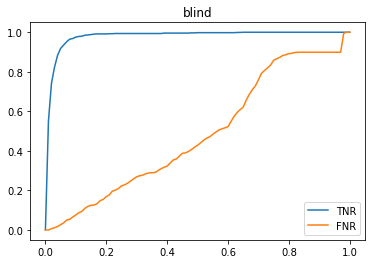

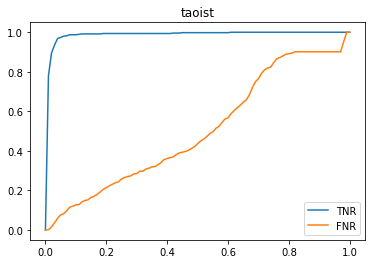

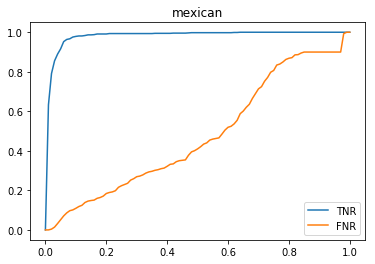

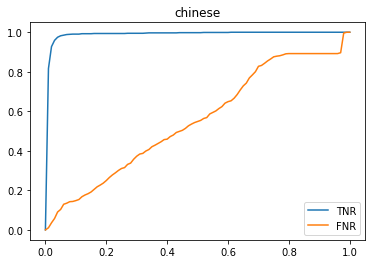

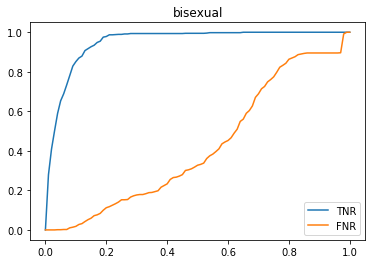

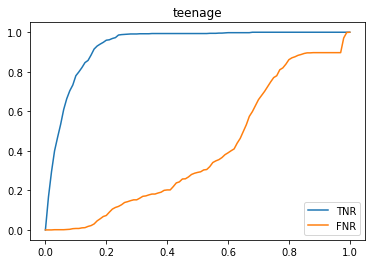

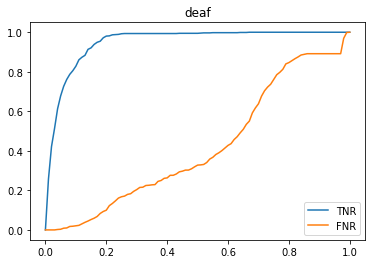

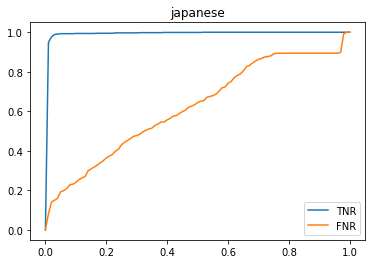

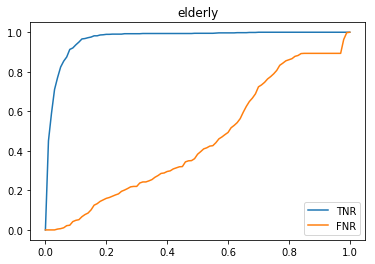

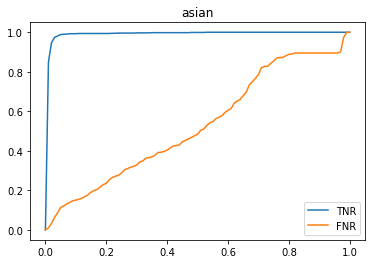

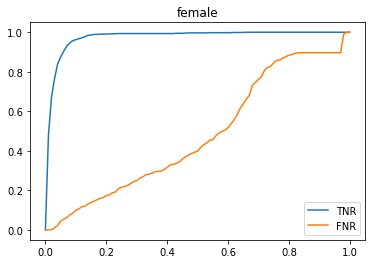

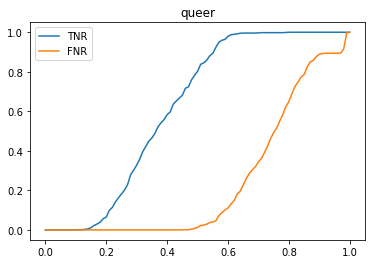

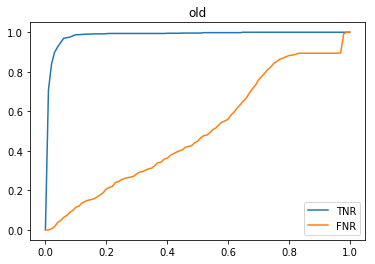

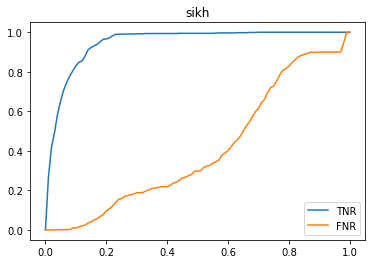

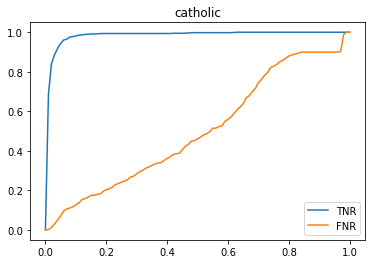

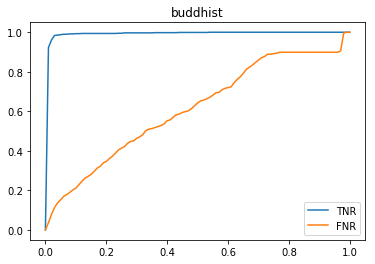

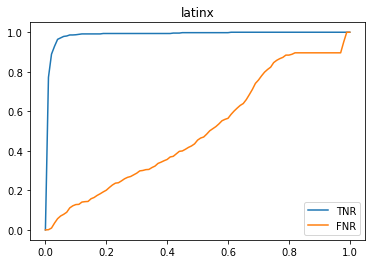

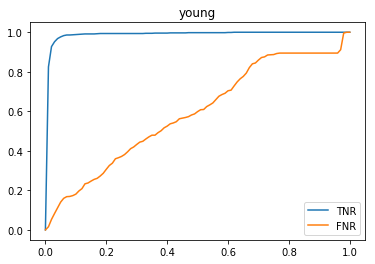

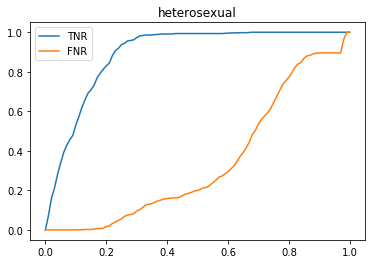

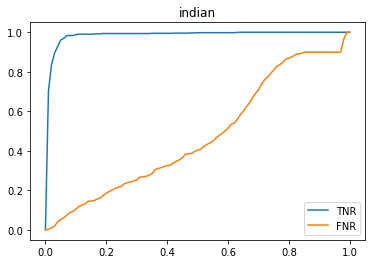

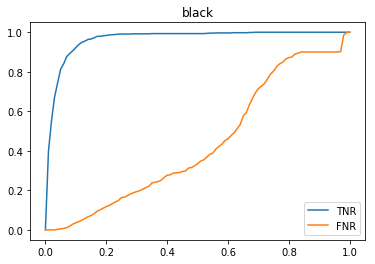

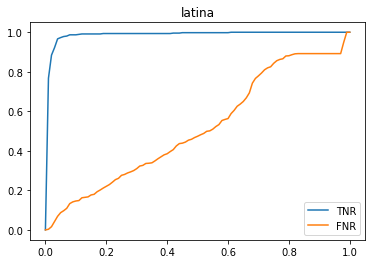

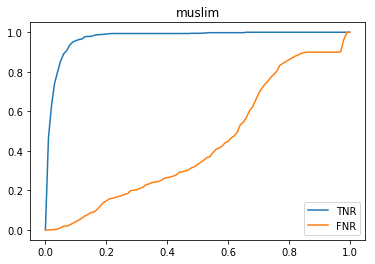

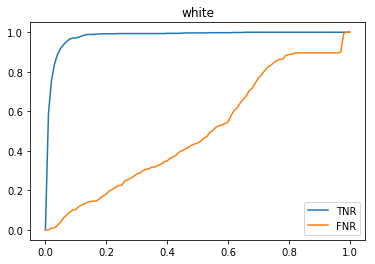

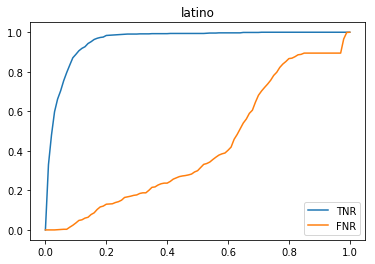

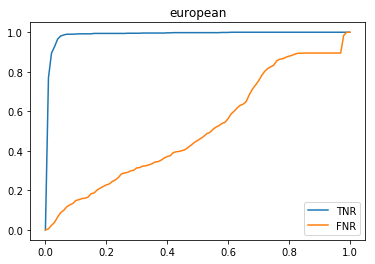

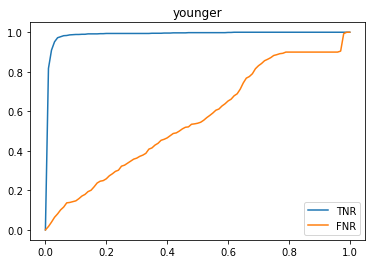

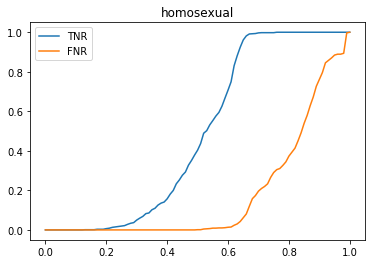

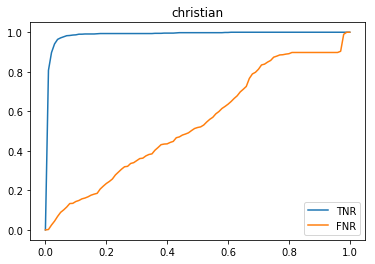

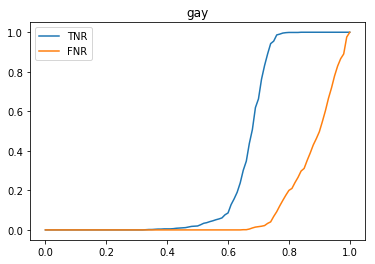

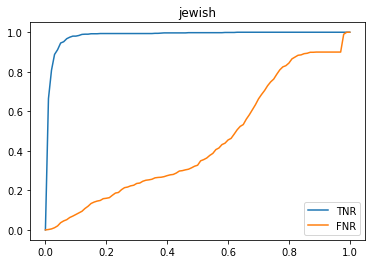

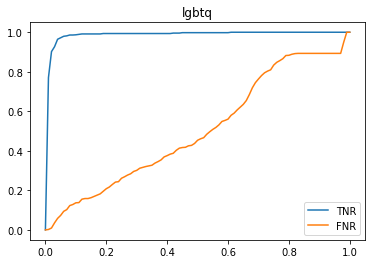

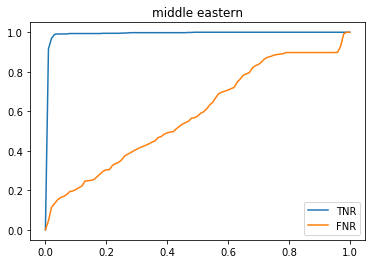

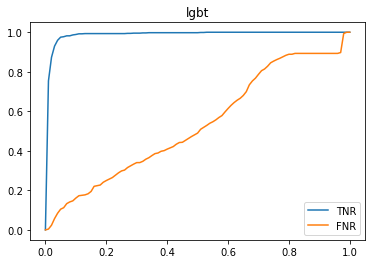

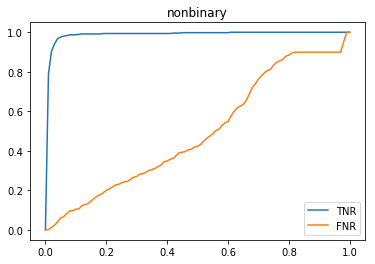

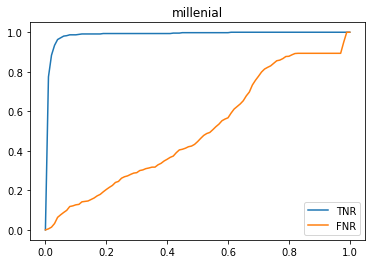

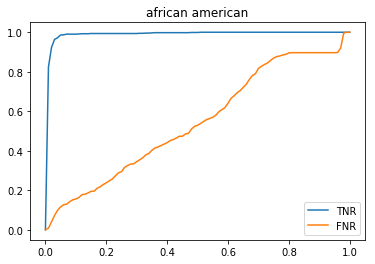

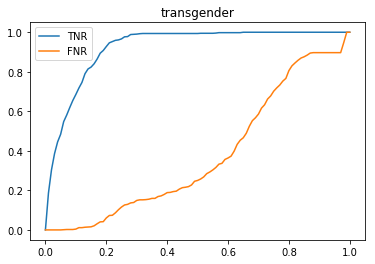

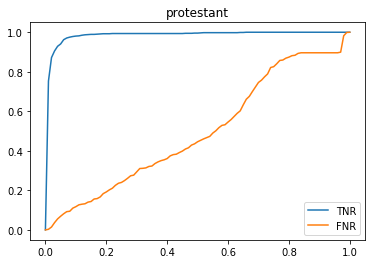

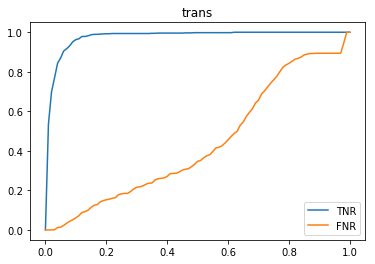

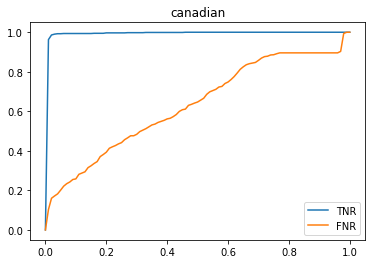

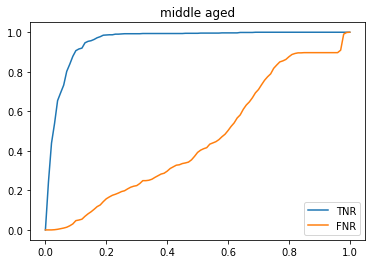

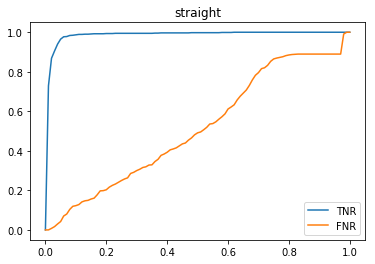

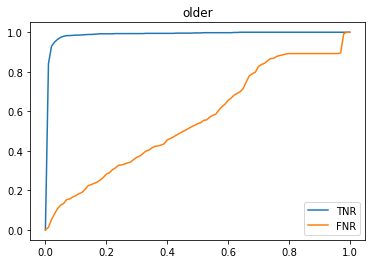

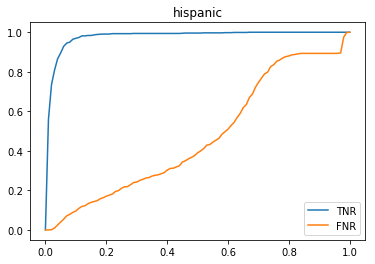

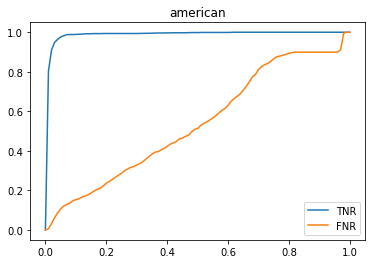

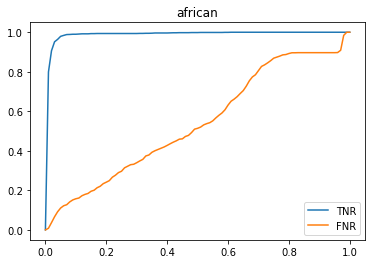

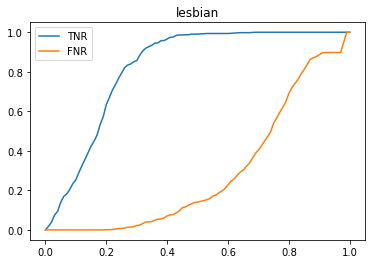

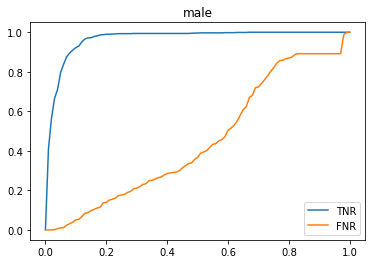

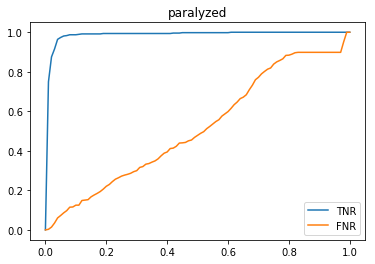

In [88]:
plot_negative_rates_by_term(thresholds = thresholds, rates_dict = rates_dict)

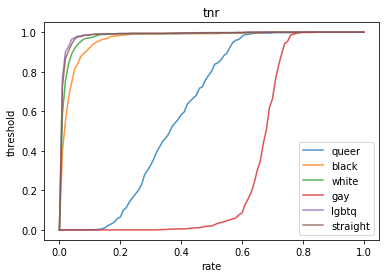

In [89]:
plot_rates_all_terms(thresholds = thresholds, terms = ['gay', 'queer', 'straight', 'black', 'white', 'lgbtq'], alpha = 0.8, rates_dict = rates_dict)

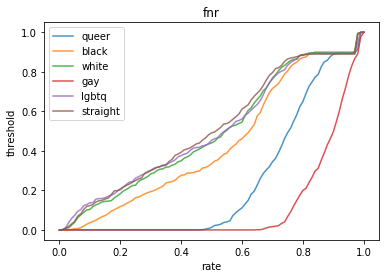

In [100]:
plot_rates_all_terms(thresholds = thresholds, terms = ['gay', 'queer', 'straight', 'black', 'white', 'lgbtq'], rate_type = 'fnr', alpha = 0.8, rates_dict = rates_dict)

In [96]:
ratio_of_rates('straight', 'gay', 0.5, rate_type = 'tnr', rates_dict = rates_dict)

50.1536521041165

In [97]:
ratio_of_rates('straight', 'gay', 0.5, rate_type = 'fnr', rates_dict = rates_dict)

'Dividing by 0'

In [99]:
ratio_of_rates('white', 'black', 0.5, rate_type = 'tnr', rates_dict = rates_dict)

1.003536063386644

In [98]:
ratio_of_rates('white', 'black', 0.5, rate_type = 'tnr', rates_dict = rates_dict)

1.003536063386644

### Equal Error Rate Threshold

In [30]:
def get_equal_error_rate(num_thresholds = 1001):
    thresholds = np.linspace(0, 1, num_thresholds)
    min_threshold = -1
    min_diff = -1
    min_confusion_matrix = -1
    for threshold in thresholds:
        confusion_matrix = confusion_matrix_counts(madlibs, 'score', 'label', threshold)
        difference = np.absolute(confusion_matrix['fn'] - confusion_matrix['fp'])
        if min_diff == -1 or difference < min_diff:
            min_threshold = threshold
            min_diff = difference
            min_confusion_matrix = confusion_matrix
    return min_threshold, min_confusion_matrix

In [31]:
%%time
get_equal_error_rate()

CPU times: user 10.5 s, sys: 32.4 ms, total: 10.6 s
Wall time: 10.6 s


(0.107, {'fn': 5029, 'fp': 5003, 'tn': 39433, 'tp': 40018})